# Advanced Evolutionary Algorithms

We have already considered the many qualitative and quantitative parameters and design choices when implementing evolutionary algorithms. In this chapter, we will consider some more fundamental changes to the algorithm, such as hybridisation of different algorithms.

In [1]:
import random
import math
import matplotlib.pyplot as plt
import sys

## Memetic Algorithms

Since an improvement to a solution does not give us any guarantees that we are in fact moving towards the optimum, evolutionary algorithms allow non-local moves. However, evolution may take longer to fine-tune solutions, while local search does exactly this very efficiently. The term _Memetic Algorithms_ is commonly used to denote the combination of global and local search. The term sometimes also refers to the use of instance-specific knowledge in search operators, but we will focus on the combination of global and local search in this notebook.

As an example problem we consider a variation of the one-max problem, such that the search operators are simplistic, and we understand the search landscape well. We are still trying to optimise the bitstring to contain all `1`s, but assume we have a somewhat more complex fitness landscape. Given a bitstring encoding, let the fitness function be the following _hurdle_ function:

$f(x) = - \Big\lceil \frac{z(x)}{w} \Big\rceil - \frac{rem(z(x), w)}{w}$

Here $z(x)$ is the number of zeros in the bitstring $x$; $w \in \{ 2, 3, \ldots, n\}$ is the hurdle width; $rem(z(x), w)$ is the remainder of $z(x)$ divided by $w$, and $\lceil \cdot \rceil$ is the ceiling function.

It will be easiest to understand what this does by looking at the resulting fitness landscape over a limited input range.

In [2]:
w = 20

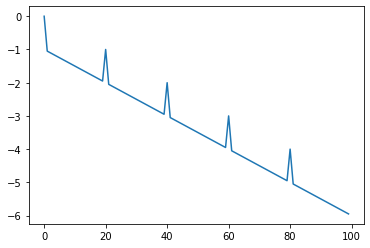

In [3]:
values = []
for z in range(0, 100):
    values.append(-math.ceil(z/w) - (z % w)/w)
plt.plot(values)

The optimal value has the fitness value $0$ (i.e. $z(0) = 0$ implies all bits are $1$). The representation is our usual bitstring, and we will use a moderate length for our bitstring:

In [4]:
n = 100

We will use our usual helper function to wrap lists in order to enable us to cache fitness values.

In [5]:
class L(list):
    """
    A subclass of list that can accept additional attributes.
    Should be able to be used just like a regular list.
    """
    def __new__(self, *args, **kwargs):
        return super(L, self).__new__(self, args, kwargs)

    def __init__(self, *args, **kwargs):
        if len(args) == 1 and hasattr(args[0], '__iter__'):
            list.__init__(self, args[0])
        else:
            list.__init__(self, args)
        self.__dict__.update(kwargs)

    def __call__(self, **kwargs):
        self.__dict__.update(kwargs)
        return self

As usual, an individual is a random sequence of bits.

In [6]:
def get_random_solution():
    domain = [0,1]
    return L([random.choice(domain) for _ in range(n)])

The fitness function calculates the hurdle function. In order to avoid redundantly calculating fitness values, we first check if the individual already has a cached fitness value, and if so, we simply return that. If we do have to calculate a new fitness value then we append an item to our `fitness_values` list; we will use this list to store the best fitness value seen to date, so that we can plot the result afterwards. We will also use it as a stopping condition, since it reliably keeps track of how many times the fitness was actually _calculated_.

In [7]:
fitness_values = []

def get_fitness(solution):
    if hasattr(solution, "fitness"):
        return solution.fitness
    
    z = len(solution) - sum(solution)
    fitness = -math.ceil(z/w) - (z % w)/w
    solution.fitness = fitness
    
    if not fitness_values:
        fitness_values.append(fitness)
    else:
        fitness_values.append(max(fitness, fitness_values[-1]))
    return fitness

In [8]:
get_fitness(get_random_solution())

-3.6

Let's first consider how local search fares with our hurdle problem. We define a neighbourhood and recall our basic hillclimber.

In [9]:
def get_neighbours(candidate):
    neighbours = []
    for pos in range(len(candidate)):
        copy = L(candidate[:])
        copy[pos] = 1 - copy[pos]
        neighbours.append(copy)
    return neighbours

As a small change to prior implementations, we will use the `fitness_values` list as a stopping condition, and make sure that we don't exceed `max_steps` fitness evaluations.

In [10]:
max_steps = 50000

In [11]:
def hillclimbing_restart():
    fitness_values.clear()
    current = get_random_solution()
    best = L(current[:])
    best_fitness = get_fitness(current)

    while len(fitness_values) < max_steps:

        best_neighbour = None
        neighbour_fitness = -sys.maxsize
        for neighbour in get_neighbours(current):
            fitness = get_fitness(neighbour)

            if fitness > neighbour_fitness:
                best_neighbour = neighbour
                neighbour_fitness = fitness

        # Random restart if no neighbour is better
        if neighbour_fitness <= get_fitness(current):
            current = get_random_solution()
            neighbour_fitness = get_fitness(current)
        else:
            current = best_neighbour                        

        if neighbour_fitness > best_fitness:
            best = L(current[:])
            best_fitness = neighbour_fitness

    return best

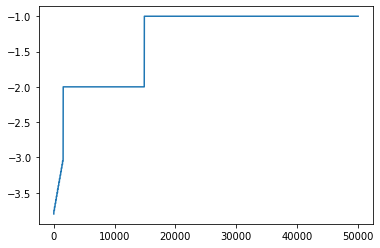

In [12]:
hillclimbing_restart()
plt.plot(fitness_values)

The hillclimber is quite unlikely to reach the optimal solution: The fitness landscape contains many local optima, and a random (re-)start needs to luckily jump beyond the last hurdle for the gradient to point to the global optimum.

Let's compare this to a basic evolutionary search algorithm; to keep things simple initially we will just use a (1+1)EA, so we just need to add a mutation function that implements the usual probabilistic bitflips:

In [13]:
def mutate(solution):
    P_mutate = 1/len(solution)
    mutated = L(solution[:])
    for position in range(len(solution)):
        if random.random() < P_mutate:
            mutated[position] = 1 - mutated[position]
    return mutated

In [14]:
def oneplusoneea():
    fitness_values.clear()
    current = get_random_solution()
    fitness = get_fitness(current)

    while len(fitness_values) < max_steps:
        candidate = mutate(current)
        candidate_fitness = get_fitness(candidate)
        if candidate_fitness >= fitness:
            fitness = candidate_fitness
            current = candidate

    return candidate

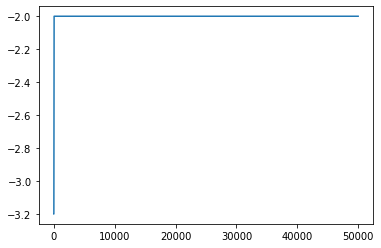

In [15]:
oneplusoneea()
plt.plot(fitness_values)

The hurdles are problematic also for this global search algorithm: The search not only needs to jump over all hurdles, but it also needs to jump higher than the preceding hurdles. Again the result tends to be that the algorithm does not find an optimal solution.

A memetic algorithm combines these two algorithms, and can overcome these problems: The global search can effectively jump over hurdles, and the local search can climb the next hurdle. As an initial memetic algorithm we create a simple (1+1)MA. For this we will adapt the hillclimber so that it takes a starting point of the search as a parameter. To avoid spending too much time exploring the neighbourhood, we will also make this a first-ascent hillclimber:

In [16]:
def hillclimbing(starting_point):

    current = starting_point
    fitness = get_fitness(current)

    improved = True
    while improved and len(fitness_values) < max_steps:
        improved = False
        
        for neighbour in get_neighbours(current):
            neighbour_fitness = get_fitness(neighbour)

            if neighbour_fitness > fitness:
                current = neighbour
                fitness = neighbour_fitness
                improved = True
                break
        
    return current, fitness

The (1+1)MA now applies local search after each mutation step:

In [17]:
def oneplusonema():
    fitness_values.clear()
    current = get_random_solution()
    fitness = get_fitness(current)

    while len(fitness_values) < max_steps:
        candidate = mutate(current)
        candidate, candidate_fitness = hillclimbing(candidate)
        if candidate_fitness >= fitness:
            fitness = candidate_fitness
            current = candidate

    return candidate

Now let's see how the three algorithms compare on our hurdle problem:

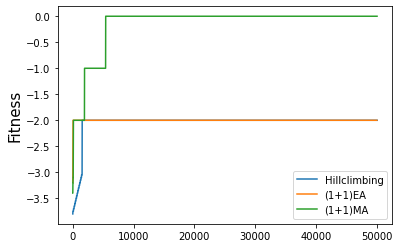

In [18]:
hillclimbing_restart()
hc_values = fitness_values[:]

oneplusoneea()
opo_values = fitness_values[:]

oneplusonema()
opoma_values = fitness_values[:]

plt.ylabel('Fitness', fontsize=15)
plt.plot(hc_values, label = "Hillclimbing")
plt.plot(opo_values, label = "(1+1)EA")
plt.plot(opoma_values, label = "(1+1)MA")
plt.legend()

The local improvement actually reflects Lamarckian evolution theory, as individuals can change their own genotype. An alternative way to implement a memetic algorithm would be to exploit the _Baldwin effect_: The genotype is not improved by the local search, but the fitness is evaluated on an improved genotype. The Baldwin effect describes how the preference of the locally improvable individuals leads to this establishing in the genotype eventually through evolution. However, when implementing algorithms we are not bound by biological realisties, so we can just implement Lamarckism.

When generalising our (1+1)MA to population-based memetic algorithms we are faced with a new parameter: Applying local improvement on _all_ offspring is intuitively very computationally expensive, as we need to explore the neighbourhoods of (potentially) many individuals. The local improvement is therefor usually only done probabilistically.

We first need all the components of a regular genetic algorithm:

In [19]:
configuration = {
    "P_xover": 0.7,
    "P_mutation": 0.01,
    "population_size": 20,
    "tournament_size": 2
}

In [20]:
def tournament_selection(population):
    # Make sure the sample isn't larger than the population
    candidates = random.sample(population, min(len(population), configuration["tournament_size"]))
    winner = max(candidates, key=lambda x: get_fitness(x))    
                
    return winner

In [21]:
def crossover(parent1, parent2):
    pos = random.randint(0, len(parent1))
    offspring1 = L(parent1[:pos] + parent2[pos:])
    offspring2 = L(parent2[:pos] + parent1[pos:])
    return offspring1, offspring2

In [22]:
def ga():
    fitness_values.clear()
    population = [get_random_solution() for _ in range(configuration["population_size"])]
    best_solution = max(population, key=lambda k: get_fitness(k))
    best_fitness = get_fitness(best_solution)

    while len(fitness_values) < max_steps:
        new_population = []

        while len(new_population) < len(population):
            parent1 = tournament_selection(population)
            parent2 = tournament_selection(population)

            if random.random() < configuration["P_xover"]:
                offspring1, offspring2 = crossover(parent1, parent2)
            else:
                offspring1, offspring2 = parent1, parent2

            offspring1 = mutate(offspring1)
            offspring2 = mutate(offspring2)

            new_population.append(offspring1)
            new_population.append(offspring2)

        population.clear()
        population.extend(new_population)

        best_solution = max(population, key=lambda k: get_fitness(k))
        best_fitness = get_fitness(best_solution)

    return best_solution

The memetic algorithm differs only by one aspect -- the probabilistic choice of applying local search:

In [23]:
configuration["P_localsearch"] = 0.1

In [24]:
def ma():
    fitness_values.clear()
    population = [get_random_solution() for _ in range(configuration["population_size"])]
    best_solution = max(population, key=lambda k: get_fitness(k))
    best_fitness = get_fitness(best_solution)

    while len(fitness_values) < max_steps:
        new_population = []

        while len(new_population) < len(population):
            parent1 = tournament_selection(population)
            parent2 = tournament_selection(population)

            if random.random() < configuration["P_xover"]:
                offspring1, offspring2 = crossover(parent1, parent2)
            else:
                offspring1, offspring2 = parent1, parent2

            offspring1 = mutate(offspring1)
            offspring2 = mutate(offspring2)

            if random.random() < configuration["P_localsearch"]:
                offspring1, offspring1_fitness = hillclimbing(offspring1)
                offspring2, offspring2_fitness = hillclimbing(offspring2)

            new_population.append(offspring1)
            new_population.append(offspring2)

        population = new_population

        best_solution = max(population, key=lambda k: get_fitness(k))
        best_fitness = get_fitness(best_solution)

    return best_solution

As a baseline for our experiments, we will also use a random search as usual:

In [25]:
def randomsearch():
    fitness_values.clear()
    best = get_random_solution()
    best_fitness = get_fitness(best)

    while len(fitness_values) < max_steps:
        candidate = get_random_solution()
        fitness = get_fitness(candidate)
        if fitness > best_fitness:
            best = candidate
            best_fitness = fitness

    return best

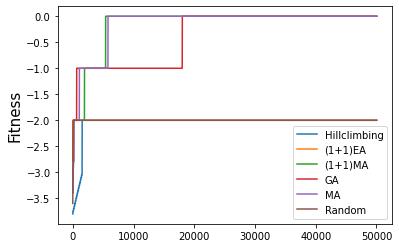

In [26]:
ga()
ga_values = fitness_values[:]

ma()
ma_values = fitness_values[:]

randomsearch()
random_values = fitness_values[:]

plt.ylabel('Fitness', fontsize=15)
plt.plot(hc_values, label = "Hillclimbing")
plt.plot(opo_values, label = "(1+1)EA")
plt.plot(opoma_values, label = "(1+1)MA")
plt.plot(ga_values, label = "GA")
plt.plot(ma_values, label = "MA")
plt.plot(random_values, label = "Random")
plt.legend()

Individual runs may vary (and we will do a more systematic comparison later on), but generally the MA-variants tend to find optimal solutions, while the others do not.

While the memetic versions seem to have an edge over the non-memetic versions, the performance is dependent on the size of the neighbourhood: For example, if we use a large `n` in a bitstring representation, then the neighbourhood may become very large, and the exploration used in the local search may be very expensive. An upper bound on the number of fitness evaluations could prevent the local search from wasting the search budget in those cases where the local search does not actually contribute to improving the solution. We can investigate the effect of the neighbourhood size by re-running the search for different values of `n`:

In [27]:
from IPython.utils import io

def run_times(algorithm, repetitions):
    global fitness_values
    result = []
    for i in range(repetitions):
        with io.capture_output() as captured: 
            algorithm()
        result.append(fitness_values[-1])
    return result

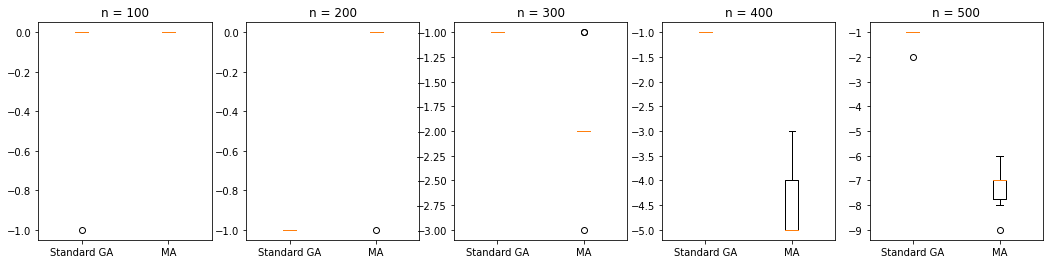

In [28]:
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(18, 4))

num_plot = 0
for n in [100, 200, 300, 400, 500]:
    results = {
        "Standard GA"  : run_times(ga, 10),
        "MA"           : run_times(ma, 10)
    }
    axes[num_plot].boxplot(results.values())
    axes[num_plot].set_title(f"n = {n}")
    axes[num_plot].set_xticklabels(results.keys())
    num_plot += 1
plt.show()

As a point for comparison, let's also consider the standard one-max problem for the same sizes, where we should see a bit more spread in terms of fitness values:

In [29]:
hurdle_fitness = get_fitness

In [30]:
def get_fitness(solution):
    if hasattr(solution, "fitness"):
        return solution.fitness
    
    fitness = sum(solution)
    solution.fitness = fitness
    
    if not fitness_values:
        fitness_values.append(fitness)
    else:
        fitness_values.append(max(fitness, fitness_values[-1]))
    return fitness

In [31]:
onemax_fitness = get_fitness

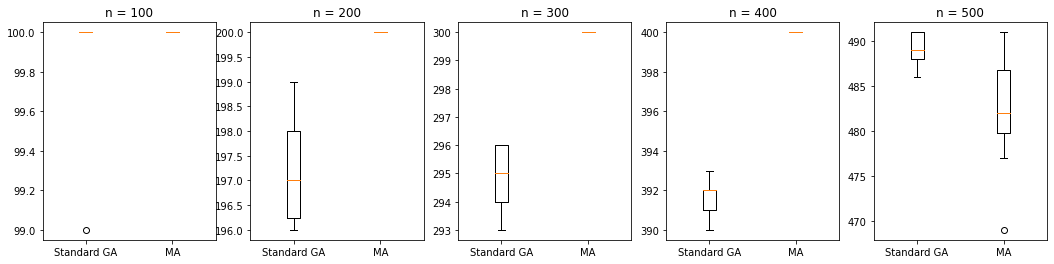

In [32]:
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(18, 4))

num_plot = 0
for n in [100, 200, 300, 400, 500]:
    results = {
        "Standard GA"  : run_times(ga, 10),
        "MA"           : run_times(ma, 10)
    }
    axes[num_plot].boxplot(results.values())
    axes[num_plot].set_title(f"n = {n}")
    axes[num_plot].set_xticklabels(results.keys())
    num_plot += 1
plt.show()

In [33]:
# Restore 
get_fitness = hurdle_fitness
n = 100

## Parallel Evolutionary Algorithms

The easiest way to parallelise evolutionary algorithms is to conduct _independent runs_. This requires no adaptation at all, and the probability of finding an optimal solution increases with the number of parallel runs. _Master-slave_ models represent a slight modification of evolutionary search, which exploits the fact that reproduction and fitness evaluation of a population is an embarrassingly parallel problem: A master distributes the work of producing and evaluating offspring for the next population to a number of slaves. The master then waits until all slaves have completed, and continues with the next iteration.

The _island model_ extends the notion of independent runs: There are independent sub-populations (islands); these islands evolve independently, but periodically exchange individuals (migration).

An island model implies a number of parameters: 
- An emigration policy which decides whether migrants are removed from source population, or whether only copies migrate (pollination).
- A selection policy which decides which individuals emigrate (e.g. best, worst, or random)
- An immigration policy which decides how immigrants are integrated (e.g. replace worst individual, random individuals, or use standard selection mechanism for replacement)
- A migration interval or frequencz which decides how often and when migration takes place
- The migration size decides how many individuals can migrate
- A migration topology decides which islands may exchange individuals. This is typically handled using directed graphs with islands as nodes and directed edges connecting islands; iondividuals can migrate only along edges of the graph


As an example, we will let the best individuals emigrate, but use pollination, such that only copies migrate.

In [34]:
configuration["emigration_size"] = 3

In [35]:
def emigrate(population):
    sorted_population = sorted(population, key=lambda k: get_fitness(k), reverse=True)
    return sorted_population[:configuration["emigration_size"]]

We will use an elitist immigration policy, where we merge the population with the immigrants, and then select the best matching the population size:

In [36]:
def immigrate(population, immigrants):
    population.sort(key=lambda k: get_fitness(k))
    for pos in range(len(immigrants)):
        population[pos] = immigrants[pos]
    return population

We will use a simple ring topology where each island can only send immigrants to the next island.

In [37]:
configuration["num_islands"] = 5
configuration["island_size"] = configuration["population_size"]

Each subpopulation evolves independently using the standard evolution mechanisms, so we can extract the usual evolution step function:

In [38]:
def evolution_step(population):
    new_population = []
    while len(new_population) < len(population):
        parent1 = tournament_selection(population)
        parent2 = tournament_selection(population)

        if random.random() < configuration["P_xover"]:
            offspring1, offspring2 = crossover(parent1, parent2)
        else:
            offspring1, offspring2 = parent1, parent2

        offspring1 = mutate(offspring1)
        offspring2 = mutate(offspring2)

        new_population.append(offspring1)
        new_population.append(offspring2)

    population.clear()
    population.extend(new_population)

    best_fitness = max([get_fitness(k) for k in population])
    return best_fitness

The GA itself is now responsible for creating the islands, and for controlling the migration between the islands according to the migration parameters. There is one major limitation to our implementation: We will not use multi-threading to actually let the islands evolve independently. While this would be easy in principle, the comparison with other algorithm versions would become moretricky. Thus, our implementation will just evaluate the effects of subpopulations and migration, and if you want to speed things up, you can extend the implementation to let the islands evolve in their own threads or processes.

In [39]:
def parallel_ga():
    fitness_values.clear()
    islands = []
    for i in range(configuration["num_islands"]):
        islands.append([get_random_solution() for _ in range(configuration["island_size"])])

    iteration = 0
    best_solution = max([y for x in islands for y in x], key=lambda k: get_fitness(k))
    best_fitness = get_fitness(best_solution)

    while len(fitness_values) < max_steps:
        iteration += 1

        for i in range(configuration["num_islands"]):
            migrants = emigrate(islands[i])
            target = i + 1 if i < configuration["num_islands"] - 1 else 0
            immigrate(islands[target], migrants)

        for i in range(configuration["num_islands"]):
            island_fitness = evolution_step(islands[i])
            if island_fitness > best_fitness:
                best_fitness = island_fitness

    best = max([y for x in islands for y in x], key=lambda k: get_fitness(k))
    return best

To see how the migration affects the search, let's briefly move away from our complicated hurdle fitness landscape to the easier one-max problem with its nice gradient.

In [40]:
get_fitness = onemax_fitness
n = 500

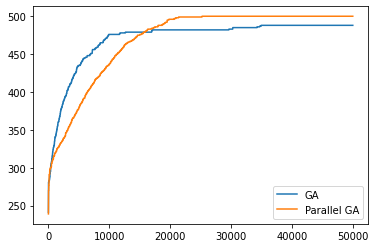

In [41]:
ga()
values_ga = fitness_values[:]

parallel_ga()
values_pga = fitness_values[:]

plt.plot(values_ga, label="GA")
plt.plot(values_pga, label="Parallel GA")
plt.legend()

There usually are two things noticable in the plot: First, evolution may initially be a bit slower since we set the island population size the same as the population size, so there's more to evaluate initially. However, over time the effects should show how the migration leads to an overall higher fitness value.

## Cellular Evolutionary Algorithms

A cellular evolutionary algorithm is a special case of an island model with more fine-grained form of parallelisation: 
Each island (cell) contains only a single individual. During reproduction, an individual is only allowed to mate with its neighbours, as defined by the topology (commonly rings, grids, or two-dimensional torus graphs).

Let's put our population into a grid, i.e. a two-dimensional list. Let's assume we consider only the 4-neighbourhood (von Neumann neighbourhood) during selection, then we randomly select one of these 4 neighbours:

In [42]:
def grid_selection(population, row, col):
    neighbours = []
    for dx in [-1, 1]:
        if row + dx >= 0 and row + dx < len(population):
            neighbours.append(population[row + dx][col])
    for dy in [-1, 1]:
        if col + dy >= 0 and col + dy < len(population):
            neighbours.append(population[row][col + dy])

    return random.choice(neighbours)

The genetic algorithm needs to be modified such that the population is a properly initialised grid, and then uses the `grid_selection` we just defined:

In [43]:
configuration["grid_size"] = 5

In [44]:
def cellular_ga():
    fitness_values.clear()
    population = [[get_random_solution() for _ in range(configuration["grid_size"])] for _ in range(configuration["grid_size"])]

    best_solution = max([y for x in population for y in x], key=lambda k: get_fitness(k))
    best_fitness = get_fitness(best_solution)

    while len(fitness_values) < max_steps:
        new_population = []
        for row in range(configuration["grid_size"]):
            new_population.append([])
            for col in range(configuration["grid_size"]):
                parent1 = grid_selection(population, row, col)
                parent2 = grid_selection(population, row, col)

                if random.random() < configuration["P_xover"]:
                    offspring1, offspring2 = crossover(parent1, parent2)
                else:
                    offspring1, offspring2 = L(parent1[:]), L(parent2[:])

                offspring = mutate(random.choice([offspring1, offspring2]))

                if get_fitness(offspring) >= get_fitness(population[row][col]):
                    new_population[row].append(offspring)
                else:
                    new_population[row].append(population[row][col])

        population = new_population
        best_solution = max([y for x in population for y in x], key=lambda k: get_fitness(k))
        best_fitness = get_fitness(best_solution)

    return best_solution

When producing the next generation the cellular GA iterates over the grid, and produces an offspring at each grid location using only the neighbourhood for reproduction. We have implemented an elitist approach where the grid location is only replaced with the offspring if the offspring has the same or better fitness.

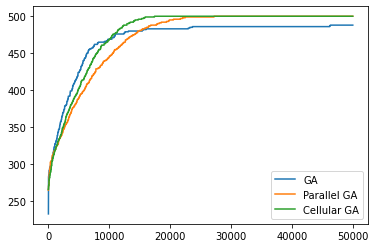

In [45]:
ga()
values_ga = fitness_values[:]

parallel_ga()
values_pga = fitness_values[:]

cellular_ga()
values_cga = fitness_values[:]


plt.plot(values_ga, label="GA")
plt.plot(values_pga, label="Parallel GA")
plt.plot(values_cga, label="Cellular GA")
plt.legend()

For larger grids the cellular GA may be slower initially -- it takes longer for genetic material to spread across the population of a large grid. This, however, is also its benefit: Premature convergence is less likely to occur.

Now let's get back to the hurdle function (where parallelising probably does not lead to visible benefits).

In [46]:
get_fitness = hurdle_fitness
n = 100

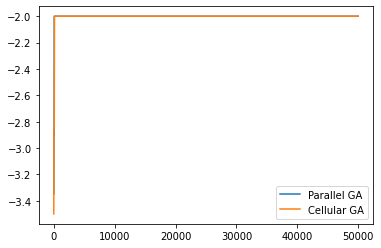

In [47]:
parallel_ga()
pga_values = fitness_values[:]

cellular_ga()
cellularga_values = fitness_values[:]

plt.plot(pga_values, label = "Parallel GA")
plt.plot(cellularga_values, label = "Cellular GA")
plt.legend()

On the hurdle function the parallel and cellular GAs probably struggle like all the other purely global evolutionary algorithms. However, in principle it would be easy to extend these algorithms to _memetic_ versions:

In [48]:
def evolution_step_ma(population):
    new_population = []
    while len(new_population) < len(population):
        parent1 = tournament_selection(population)
        parent2 = tournament_selection(population)

        if random.random() < configuration["P_xover"]:
            offspring1, offspring2 = crossover(parent1, parent2)
        else:
            offspring1, offspring2 = parent1, parent2

        offspring1 = mutate(offspring1)
        offspring2 = mutate(offspring2)

        if random.random() < configuration["P_localsearch"]:
            offspring1, offspring1_fitness = hillclimbing(offspring1)
        if random.random() < configuration["P_localsearch"]:
            offspring2, offspring2_fitness = hillclimbing(offspring2)

        new_population.append(offspring1)
        new_population.append(offspring2)

    population.clear()
    population.extend(new_population)

    best_fitness = max([get_fitness(k) for k in population])
    return best_fitness

In [49]:
def parallel_ma():
    fitness_values.clear()
    islands = []
    for i in range(configuration["num_islands"]):
        islands.append([get_random_solution() for _ in range(configuration["island_size"])])

    iteration = 0
    best_solution = max([y for x in islands for y in x], key=lambda k: get_fitness(k))
    best_fitness = get_fitness(best_solution)

    while len(fitness_values) < max_steps:
        iteration += 1

        for i in range(configuration["num_islands"]):
            migrants = emigrate(islands[i])
            target = i + 1 if i < configuration["num_islands"] - 1 else 0
            immigrate(islands[target], migrants)

        for i in range(configuration["num_islands"]):
            island_fitness = evolution_step_ma(islands[i])
            if island_fitness > best_fitness:
                best_fitness = island_fitness

    best = max([y for x in islands for y in x], key=lambda k: get_fitness(k))
    return best

In [50]:
def cellular_ma():
    fitness_values.clear()
    population = [[get_random_solution() for _ in range(configuration["grid_size"])] for _ in range(configuration["grid_size"])]

    best_solution = max([y for x in population for y in x], key=lambda k: get_fitness(k))
    best_fitness = get_fitness(best_solution)

    while len(fitness_values) < max_steps:
        new_population = []
        for row in range(configuration["grid_size"]):
            new_population.append([])
            for col in range(configuration["grid_size"]):
                parent1 = grid_selection(population, row, col)
                parent2 = grid_selection(population, row, col)

                if random.random() < configuration["P_xover"]:
                    offspring1, offspring2 = crossover(parent1, parent2)
                else:
                    offspring1, offspring2 = L(parent1[:]), L(parent2[:])

                offspring = mutate(random.choice([offspring1, offspring2]))
                if random.random() < configuration["P_localsearch"]:
                    offspring, offspring_fitness = hillclimbing(offspring)

                if get_fitness(offspring) >= get_fitness(population[row][col]):
                    new_population[row].append(offspring)
                else:
                    new_population[row].append(population[row][col])

        population = new_population
        best_solution = max([y for x in population for y in x], key=lambda k: get_fitness(k))
        best_fitness = get_fitness(best_solution)

    return best_solution

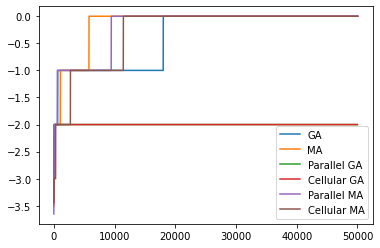

In [51]:
parallel_ma()
pma_values = fitness_values[:]

cellular_ma()
cellularma_values = fitness_values[:]

plt.plot(ga_values, label = "GA")
plt.plot(ma_values, label = "MA")
plt.plot(pga_values, label = "Parallel GA")
plt.plot(cellularga_values, label = "Cellular GA")
plt.plot(pma_values, label = "Parallel MA")
plt.plot(cellularma_values, label = "Cellular MA")
plt.legend()

## Estimation of Distribution Algorithms

In a genetic algorithm we select (stochastically) from the population, which, technically, is akin to sampling from an unknown distribution. The idea of Estimation of Distribution Algorithms (EDA) is to replace the population with a _model_ of that distribution, and the stochastic operators are then replaced with repeated estimation of the model.

An EDA consists of:
- A selection operator for selecting promising solutions (same as in GA)
- An assumed class of probabilistic models to use for modelling and sampling
- A procedure for learning a probabilistic model for the selected solutions
- A procedure for sampling the built probabilistic model
- A replacement operator for combining the populations of old and new candidate solutions (same as in GA)

Different instances of EDAs differ mainly in the class of probabilistic models and the procedures used for evaluating candidates models and searching for a good model.

There are two main classes of EDAs: Those based on an explicit population, and algorithms that are purely incremental.

### Compact Genetic Agorithm (CGA)


A compact genetic algorithm (CGA) is an incremental EDA. We start with an initial probability distribution (e.g., randomly initialised, or uniform probabilities). We then sample solutions from that distribution, and select the best and the worst of the sample set. These two are then used to update the probability distribution to make it the better individual more likely in that distribution, and the worse individual less likely.

As a first step we need to decide on a probabilistic model to represent our solution space (bitstrings). A very simple model would be to assign each bit in our bitstring of length `n` a probability of this bit being 1. Thus, if we want to draw a sample from the distribution we would iterate over the `n` probabilities, and append a `1` at position $i$ with the probability $p_i$:

In [52]:
def sample(distribution):
    solution = []
    for p in distribution:
        if random.random() < p:
            solution.append(1)
        else:
            solution.append(0)

    return L(solution)

We will start with all probabilities $p_i$ set to 0.5, such that sampled solutions are completely random at first. At each step, given the better sampled solution $x$ and the worse sampled solution $y$, we update the probability for each bit as follows for each bit $i$:
- If $x_i = y_i$ then the probability of bit $i$ is unchanged
- If $x_i - y_i = 1$ then the probability of bit $i$ being 1 is increased, since $x_i$ was 1 and $y_i$ was 0.
- If $x_i - y_i = -1$ then the probability of bit $i$ being 1 is decreased, since $x_i$ was 0 and $y_i$ was 1.

The rate at which the probability is updated depends on a parameter $\lambda$, which is essentially $1/N$ for a hypothetical population size $N$. Thus, the probability update function is:

$$
p_{t+1}(i) = p_t(i) + \lambda \cdot (x_i - y_i)
$$

We thus need to set our parameters. Besides $\lambda$, we also need to decide how many samples to draw. The number of samples essentially represents the selective pressure.

In [53]:
# Number of samples
# -> Selection pressure
configuration["num_samples"] = 2

# Learning rate ( 1 / N -- Hypothetical population size)
configuration["lambda"] = 0.005

In [54]:
def cga():
    fitness_values.clear()
    distribution = [0.5 for _ in range(n)]
    best_fitness = -sys.maxsize
    best_individual = None
    while len(fitness_values) < max_steps:
        candidates = [sample(distribution) for _ in range(configuration["num_samples"])]
        best  = max(candidates, key=lambda k: get_fitness(k))
        worst = min(candidates, key=lambda k: get_fitness(k))

        for i in range(n):
            distribution[i] = distribution[i] + configuration["lambda"] * (best[i] - worst[i])

        if get_fitness(best) > best_fitness:
            best_individual = best
            best_fitness = get_fitness(best)

    return best_individual        

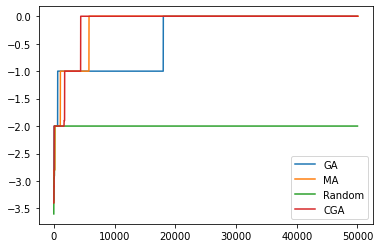

In [55]:
cga()
cga_values = fitness_values[:]

plt.plot(ga_values, label = "GA")
plt.plot(ma_values, label = "MA")
plt.plot(random_values, label = "Random")
plt.plot(cga_values, label = "CGA")
plt.legend()

### Population-based incremental learning (PBIL) 

PBIL is an alternative incremental EDA strategy. It is based on the same probabilistic model, but instead of updating the probabilities based on the difference between the best and worst sampled solution, the probabilities are updated based on the difference between the best sample and the _current_ distribution. That is, the main difference lies in the update function. Given the best individual $x$ from the current sample:

$$
p_{t+1}(i) = p_t(i) + \lambda \cdot (x_i - p_t(i))
$$

If the best individual $x$ contains a $1$ at bit $i$, then the probability is updated (unless it is already 1.0) based on $x_i - p_t(i)$. If $x$ contains a $0$, then the difference will be negative, thus decreasing the probability.

In [56]:
def pbil():
    fitness_values.clear()
    distribution = [0.5 for _ in range(n)]
    best_fitness = -1
    best_individual = None
    while len(fitness_values) < max_steps:
        candidates = [sample(distribution) for _ in range(configuration["num_samples"])]
        best = max(candidates, key=lambda k: get_fitness(k))

        for i in range(n):
            distribution[i] = distribution[i] + configuration["lambda"] * (best[i] - distribution[i])

        if get_fitness(best) > best_fitness:
            best_individual = best
            best_fitness = get_fitness(best)

    return best_individual

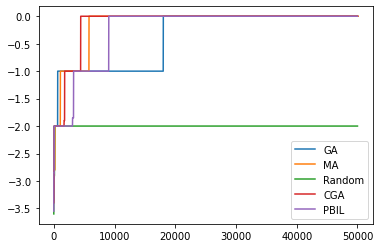

In [57]:
pbil()
pbil_values = fitness_values[:]

plt.plot(ga_values, label = "GA")
plt.plot(ma_values, label = "MA")
plt.plot(random_values, label = "Random")
plt.plot(cga_values, label = "CGA")
plt.plot(pbil_values, label = "PBIL")
plt.legend()

### Univariate Marginal Distribution Algorithm (UMDA)

The final variant of an EDA we consider, the Univariate Marginal Distribution Algorithm (UMDA), is a population-based EDA. Like in a regular GA we maintain a population of solutions. For each iteration, we select a population of promising solutions using regular selection operators. Then, we compute a probability vector on this selected population of promising solutions, and generate the next generation by sampling this probability vector. This newly sampled population replaces the old one. 

We will use a simple _truncation selection_ operator that selects the top 50% of the population. The probability for bit $i$ is estimated as the number of $1$s that occur at bit $i$ out of the selected individuals.

In [58]:
def umda():
    sample_size = configuration["population_size"]//2
    fitness_values.clear()
    population = [get_random_solution() for _ in range(configuration["population_size"])]
    population.sort(key=lambda k: get_fitness(k), reverse=True)
    best_individual = population[0]
    best_fitness = get_fitness(best_individual)
    
    while len(fitness_values) < max_steps:
        subset = population[:sample_size]
        distribution = []
        for i in range(n):
            values = [x[i] for x in subset]
            distribution.append((sum(values) + 1) / (len(values) + 1))

        population = [sample(distribution) for _ in range(configuration["population_size"])]
        population.sort(key=lambda k: get_fitness(k), reverse=True)

        candidate = population[0]
        fitness = get_fitness(candidate)
        if fitness > best_fitness:
            best_fitness = fitness
            best_individual = candidate

    return best_individual

There is one import aspect when calculating probability estimates for each bit: If we happen to select a population where all instances have that bit set to 0, then the probability of sampling that bit will become 0. Thus, all future generations would definitely take the value 0, and it would be impossible for the algorithm to ever sample a 1 again at that position. To avoid this from happening, we apply Laplace correction in the probability update.

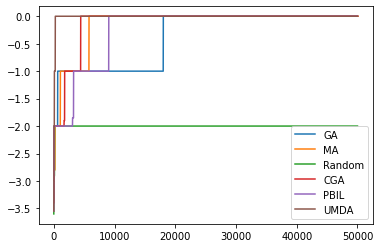

In [59]:
umda()
umda_values = fitness_values[:]

plt.plot(ga_values, label = "GA")
plt.plot(ma_values, label = "MA")
plt.plot(random_values, label = "Random")
plt.plot(cga_values, label = "CGA")
plt.plot(pbil_values, label = "PBIL")
plt.plot(umda_values, label = "UMDA")
plt.legend()

Let's look at the performance of the EDA algorithms compared to some other baseline algorithms for a slightly more challenging value of `n`:

[Text(1, 0, 'Random'),
 Text(2, 0, 'Standard GA'),
 Text(3, 0, 'MA'),
 Text(4, 0, 'CGA'),
 Text(5, 0, 'PBIL'),
 Text(6, 0, 'UMDA')]

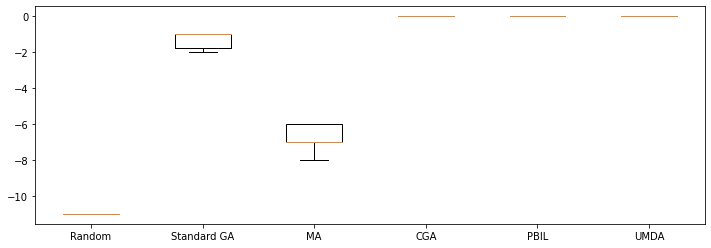

In [60]:
n = 500
results = {
    "Random"       : run_times(randomsearch, 10),
    "Standard GA"  : run_times(ga, 10),
    "MA"           : run_times(ma, 10),
    "CGA"          : run_times(cga, 10),
    "PBIL"         : run_times(pbil, 10),
    "UMDA"         : run_times(umda, 10)
}
fig, ax = plt.subplots(figsize=(12,4))
ax.boxplot(results.values())
ax.set_xticklabels(results.keys())

## Differential Evolution

Differential evolution is a popular evolutionary algorithm in the context of nonlinear and non-differntiable continuous space functions. The algorithm maintains a population of candidate solutions that move around in the search space. In each iteration, the position of each individual of that population is updated using mathematical formulas; if the update does not lead to an improvement, the individual remains where it is.

Unlike regular evolutionary algorithms, the reproduction requires _four_ individuals. While updating the population, for each 

Assuming we have a candidate target individual $x_t$, then we select three further individuals $x_1$, $x_2$, and $x_3$. First, we create a mutant $m$ from $x_1$, $x_2$, and $x_3$:

$$
m = m + F \cdot (x_2 - x_3)
$$

Here, $F$ is a real number controlling the rate at which the population evolves (e.g., 0.1).

Given the mutant $m$ and the target individual $x_t$, we now create a new individual using uniform crossover between $m$ and $x_t$, but with a twist: At one randomly chosen position the child allele is taken from the first parent without making a random decision (duplication of second parent not possible).

Finally, deterministic selection is applied to decide whether the resulting offspring should replace $x_t$.

While Differential Evolution was originally designed for real-valued problems, it is possible to adapt it to bitstring representations. When creating the mutant $m$, for each bit $i$ we set $m(i)$ to $1 - x_1(i)$ if $x_2(i) \neq x_3(i)$ and with probability $F$, and to $x_1(i)$ otherwise. That is, the individuals $x_2$ and $x_3$, together with a random number, decide whether each bit in $x_1$ is flipped or not. 

In [61]:
def binaryde():
    F = 0.1
    fitness_values.clear()
    population = [get_random_solution() for _ in range(configuration["population_size"])]

    while len(fitness_values) < max_steps:
        for j in range(len(population)):

            # select three random vector index positions [0, popsize), not including current vector (j)
            candidates = [i for i in range(len(population))]
            candidates.remove(j)
            random_index = random.sample(candidates, 3)

            x_1 = population[random_index[0]]
            x_2 = population[random_index[1]]
            x_3 = population[random_index[2]]
            x_t = population[j]  # target individual

            # Mutation
            mutant = L([])
            for k in range(len(x_t)):
                if x_2[k] != x_3[k] and random.random() < F:
                    mutant.append(1 - x_1[k])
                else:
                    mutant.append(x_1[k])

            # Binomial crossover
            trial = L([])
            for k in range(len(x_t)):
                if random.random() <= 0.5: #configuration["P_xover"]: #0.5: # 
                    trial.append(mutant[k])
                else:
                    trial.append(x_t[k])

            # Greedy selection
            if get_fitness(trial) >= get_fitness(x_t):
                population[j] = trial


    return max(population, key=lambda k: get_fitness(k))

Let's consider the standard one-max problem again for this comparison, as we have more fine grained fitness values.

In [62]:
get_fitness = onemax_fitness
n = 500

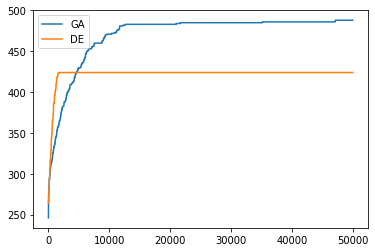

In [63]:
binaryde()
values_de = fitness_values[:]

ga()
values_ga = fitness_values[:]

plt.plot(values_ga, label = "GA")
plt.plot(values_de, label = "DE")
plt.legend()

Very likely, the differential evolution gets stuck quite soon; this is an effect of the small population sizes -- differential evolution tends to perform badly with population sizes of less than 50. Let's try again with a larger population size. For simplicity, we use the same population size for other algorithms.

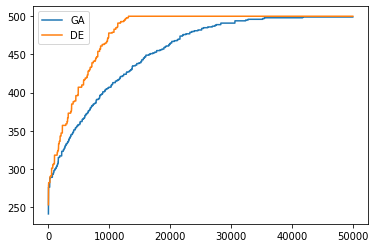

In [64]:
configuration["population_size"] = 100
binaryde()
values_de = fitness_values[:]

ga()
values_ga = fitness_values[:]

plt.plot(values_ga, label = "GA")
plt.plot(values_de, label = "DE")
plt.legend()

## Hyper Heuristics

Since we now have several different heuristics to choose from, we could implement a hyper-heuristic to choose the best one for the problem at hand. For this, we need a function that probabilistically chooses a heuristic based on its recent performance:

In [65]:
def select(heuristics, history):

    w = 5
    weights = []
    for h in heuristics:
        weights.append(max(history[h][-w:]))

    candidates = random.sample([x for x in range(len(weights))], 3)
    index = max(candidates, key=lambda k: weights[k])
    return heuristics[index]

We also need to slightly adapt our heuristics: We want to apply each heuristic only for a couple of iterations, and then let the hyper heuristic choose how to proceed. This means we require two parameters: The population which serves as starting point for the current invocation of the heuristic, and the number of iterations to be performed.

In [66]:
def hyper_ga(population, iterations):
    best_solution = max(population, key=lambda k: get_fitness(k))
    best_fitness = get_fitness(best_solution)
    iteration = 0
    
    while iteration < iterations:
        iteration += 1
        new_population = []

        while len(new_population) < len(population):
            parent1 = tournament_selection(population)
            parent2 = tournament_selection(population)

            if random.random() < configuration["P_xover"]:
                offspring1, offspring2 = crossover(parent1, parent2)
            else:
                offspring1, offspring2 = parent1, parent2

            offspring1 = mutate(offspring1)
            offspring2 = mutate(offspring2)

            new_population.append(offspring1)
            new_population.append(offspring2)

        population.clear()
        population.extend(new_population)

        best_solution = max(population, key=lambda k: get_fitness(k))
        best_fitness = get_fitness(best_solution)

    return best_solution, best_fitness, population

In [67]:
def hyper_ma(population, iterations):
    best_solution = max(population, key=lambda k: get_fitness(k))
    best_fitness = get_fitness(best_solution)
    iteration = 0
    
    while iteration < iterations:
        iteration += 1
        new_population = []

        while len(new_population) < len(population):
            parent1 = tournament_selection(population)
            parent2 = tournament_selection(population)

            if random.random() < configuration["P_xover"]:
                offspring1, offspring2 = crossover(parent1, parent2)
            else:
                offspring1, offspring2 = parent1, parent2

            offspring1 = mutate(offspring1)
            offspring2 = mutate(offspring2)

            if random.random() < configuration["P_localsearch"]:
                offspring1, offspring1_fitness = hillclimbing(offspring1)
                offspring2, offspring2_fitness = hillclimbing(offspring2)

            new_population.append(offspring1)
            new_population.append(offspring2)

        population = new_population

        best_solution = max(population, key=lambda k: get_fitness(k))
        best_fitness = get_fitness(best_solution)

    return best_solution, best_fitness, population

In [68]:
def hyper_binaryde(population, iterations):
    F = 0.1
    iteration = 0
    
    while iteration < iterations:
        iteration += 1
        for j in range(len(population)):

            # select three random vector index positions [0, popsize), not including current vector (j)
            candidates = [i for i in range(len(population))]
            candidates.remove(j)
            random_index = random.sample(candidates, 3)

            x_1 = population[random_index[0]]
            x_2 = population[random_index[1]]
            x_3 = population[random_index[2]]
            x_t = population[j]  # target individual

            # Mutation
            mutant = L([])
            for k in range(len(x_t)):
                if x_2[k] != x_3[k] and random.random() < F:
                    mutant.append(1 - x_1[k])
                else:
                    mutant.append(x_1[k])

            # Binomial crossover
            trial = L([])
            for k in range(len(x_t)):
                if random.random() <= 0.5: #configuration["P_xover"]: #0.5: # 
                    trial.append(mutant[k])
                else:
                    trial.append(x_t[k])

            # Greedy selection
            if get_fitness(trial) >= get_fitness(x_t):
                population[j] = trial

    best_individual = max(population, key=lambda k: get_fitness(k))
    best_fitness = get_fitness(best_individual)

    return best_individual, best_fitness, population

We could adapt further heuristics, and also allow further choices regarding the different qualitative and quantitative parameters. However, we'll keep it simple; the hyper-heuristic now simply runs each heuristic in turn for a number of iterations (e.g., 5) and keeps track of the improvement achieved at each step.

In [69]:
def hyper():
    fitness_values.clear()
    population =[get_random_solution() for _ in range(configuration["population_size"])]
    best_individual = max(population, key=lambda k: get_fitness(k))
    best_fitness = get_fitness(best_individual)
    step_size = 5
    heuristics = [hyper_ga, hyper_ma, hyper_binaryde] 

    history = {}
    for h in heuristics:
        # Use high value for heuristics not tried yet, to ensure they are attemped
        history[h] = [n]

    iteration = 0
    while len(fitness_values) < max_steps:
        h = select(heuristics, history)
        best_individual, next_fitness, population = h(population, step_size)

        history[h].append(next_fitness - best_fitness)
        best_fitness = next_fitness
        iteration += step_size

    for h in heuristics:
        print(f"Heuristic {h.__name__}: {len(history[h])} invocations")
        
    return best_individual

Our previous experiments have shown that the MA tends to use up substantial numbers of fitness evaluations for large values of `n` and large populations. As discussed above, we should really be limiting the number of fitness evaluations done during the local search, but to make the algorithm perform well on large values of `n` for now, we will simply reduce the probability of applying local search:

In [70]:
configuration["P_localsearch"] = 0.001

Now let's compare the individual constituent algorithms, and see whether the hyper heuristic is able to figure out the best heuristic for this problem:

Heuristic hyper_ga: 1 invocations
Heuristic hyper_ma: 2 invocations
Heuristic hyper_binaryde: 5 invocations


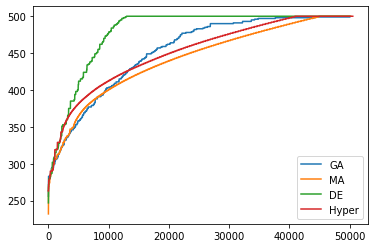

In [71]:
get_fitness = onemax_fitness

ga()
values_ga = fitness_values[:]

ma()
values_ma = fitness_values[:]

binaryde()
values_de = fitness_values[:]

hyper()
hyper_values = fitness_values[:]

plt.plot(values_ga, label = "GA")
plt.plot(values_ma, label = "MA")
plt.plot(values_de, label = "DE")
plt.plot(hyper_values, label = "Hyper")
plt.legend()

Let's also repeat this for the hurdle fitness function:

Heuristic hyper_ga: 18 invocations
Heuristic hyper_ma: 29 invocations
Heuristic hyper_binaryde: 36 invocations


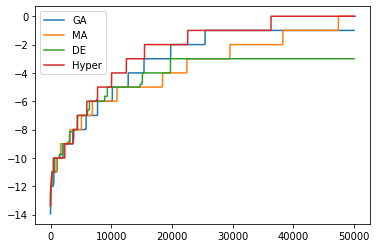

In [72]:
get_fitness = hurdle_fitness

ga()
values_ga = fitness_values[:]

ma()
values_ma = fitness_values[:]

binaryde()
values_de = fitness_values[:]

hyper()
hyper_values = fitness_values[:]

plt.plot(values_ga, label = "GA")
plt.plot(values_ma, label = "MA")
plt.plot(values_de, label = "DE")
plt.plot(hyper_values, label = "Hyper")
plt.legend()